## Modelagem de topicos através do tempo

In [5]:
%pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 825.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import unicodedata
from umap import UMAP
from hdbscan import HDBSCAN
import os
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
comments = pd.read_csv("comments_filtered.csv")
print(comments[['created_timestamp_utc']].head())
comments['month'] = pd.to_datetime(comments['created_timestamp_utc']).dt.to_period('M').astype(str)
comments['type'] = 'C'

date_month_com = comments['month']

  created_timestamp_utc
0   2022-01-01 19:16:14
1   2022-01-01 19:16:20
2   2022-01-01 20:33:19
3   2022-01-01 23:30:43
4   2022-01-02 01:08:38


In [8]:
submissions = pd.read_csv("submissions_filtered.csv")
print(submissions[['created_timestamp_utc']].head())
submissions['month'] = pd.to_datetime(submissions['created_timestamp_utc']).dt.to_period('M').astype(str)
submissions['type'] = 'S'

date_month_sub = submissions['month']

  created_timestamp_utc
0   2022-01-13 11:42:41
1   2022-01-18 17:36:20
2   2022-01-19 02:58:23
3   2022-01-19 21:07:55
4   2022-01-22 13:39:24


In [9]:
# concatenate the two numpy arrays
date_month = pd.concat([date_month_com, date_month_sub], ignore_index=True)

print(date_month.value_counts().sort_index())


month
2022-01    1077
2022-02    9436
2022-03    9458
2022-04    2158
2022-05    2944
2022-06    1480
2022-07    1513
2022-08    1036
2022-09    2166
2022-10    2627
2022-11    2204
2022-12    1484
Name: count, dtype: int64


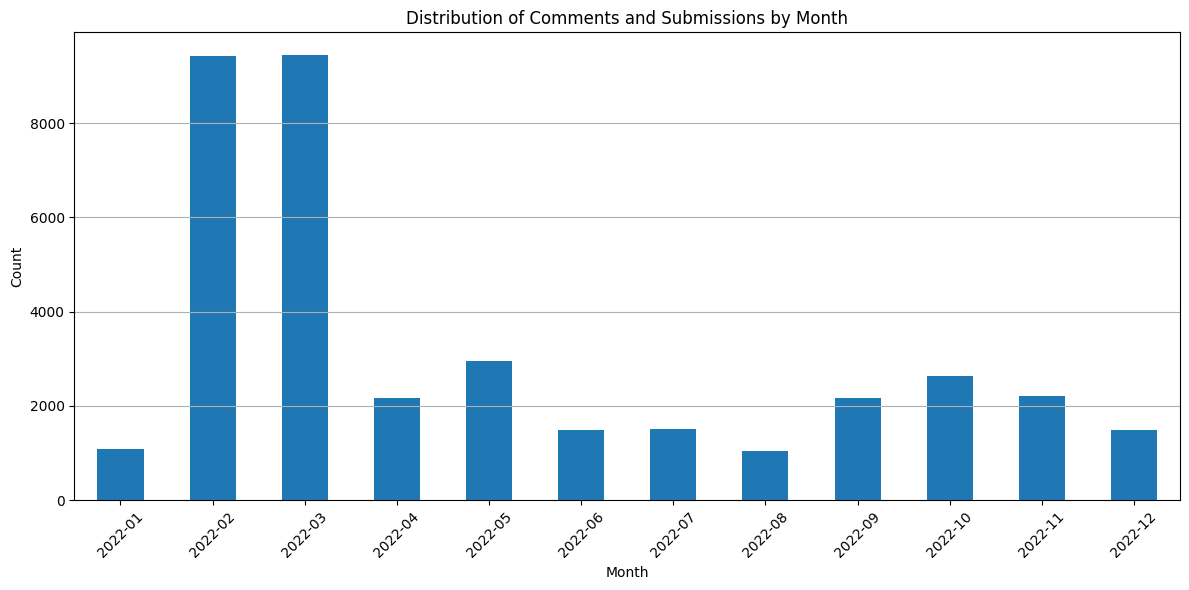

In [10]:
# plot distribution of comments and submissions by month
date_month.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Comments and Submissions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [11]:
data_comments = comments[['id', 'body', 'month', 'type']].rename(columns={'body': 'text', 'month': 'date'})
print(data_comments.head())
print(data_comments.shape)
data_submissions = submissions[['id', 'selftext', 'month', 'type']].rename(columns={'selftext': 'text', 'month': 'date'})
print(data_submissions.head())
print(data_submissions.shape)

# concatenate the two dataframes
data = pd.concat([data_comments, data_submissions], ignore_index=True)
data.columns = ['id', 'text', 'month', 'type']
print(data.head())
print(data.shape)

        id                                               text     date type
0  hqu6678  Eu não coloco a tua experiência em causa, mas ...  2022-01    C
1  hqu66rn  &gt;Farmaajo tem sido apoiado por muito tempo ...  2022-01    C
2  hquhhht  O que é dar certo? Porque pensa bem, o país er...  2022-01    C
3  hqv6rub  O embargo é dos EUA. Eles podem fazer negócios...  2022-01    C
4  hqvk4xj  a Ucrânia voltar ao seu estado natural de naçã...  2022-01    C
(36854, 4)
       id                                               text     date type
0  s2xl48  Conclamo meus colegas redditors a ouvirem/vere...  2022-01    S
1  s72yze  \- Apoio a Russia. Lutaria se pedissem.   \n\-...  2022-01    S
2  s7fnwt  Olhem o vídeo, por exemplo, de uma matéria fal...  2022-01    S
3  s80kun   Só pra saber q eu n sou o único vendo isso!? ...  2022-01    S
4  sa2q4t  Na internet já vi vários comentários de ucrani...  2022-01    S
(729, 4)
        id                                               text    month typ

In [12]:
print(stopwords.words('portuguese')[:30])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles']


### Pre-process

In [13]:
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")

    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    return text.strip()

data['text'] = data['text'].apply(preprocess_text)

### Pre-calculate embeddings

In [14]:
docs = data['text'].tolist()
timestamps = data['month'].tolist()

embeddings_path = "embeddings.npy"

if os.path.exists(embeddings_path):
    embeddings = np.load(embeddings_path)
    print("Embeddings carregadas do disco.")
else:
    embedding_model = SentenceTransformer("PORTULAN/serafim-100m-portuguese-pt-sentence-encoder")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    np.save(embeddings_path, embeddings)
    print("Embeddings calculadas e salvas no disco.")

Embeddings carregadas do disco.


### Stopwords and vectorizer

In [15]:
stopwords_pt = list(stopwords.words("portuguese"))
# apply the same preprocessing to the stopwords
stopwords_pt = [preprocess_text(word) for word in stopwords_pt]
stopwords_en = list(stopwords.words("english"))
my_stopwords = ['pra', 'gt', 'vai', 'ta', 'pq', 'vc']
final_stopwords = stopwords_pt + stopwords_en + my_stopwords


vectorizer = CountVectorizer(
    ngram_range=(1,2),
    stop_words=final_stopwords,
    max_df=0.8,
    min_df=1
)

### UMAP Dimension Reduction

In [16]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=13
)

### HDBSCAN clustering

In [17]:
hdbscan_model = HDBSCAN(
    min_cluster_size=500,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
)

In [18]:
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    calculate_probabilities=True,
    umap_model=umap_model,
    hdbscan_model= hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2025-07-06 18:36:28,661 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-06 18:38:01,895 - BERTopic - Dimensionality - Completed ✓
2025-07-06 18:38:01,898 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-06 18:38:37,635 - BERTopic - Cluster - Completed ✓
2025-07-06 18:38:37,656 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-06 18:38:49,969 - BERTopic - Representation - Completed ✓


In [19]:
### value counts of topics
print(pd.Series(topics).value_counts().sort_index())

-1    20646
 0    11759
 1     2485
 2     2186
 3      507
Name: count, dtype: int64


In [20]:
topic_model.visualize_barchart()

In [21]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

12it [05:29, 27.44s/it]


In [22]:
topic_model.visualize_topics_over_time(topics_over_time)

In [23]:
topic_model.visualize_hierarchy()

In [24]:
topic_model.visualize_heatmap()

In [25]:
topic_model.get_representative_docs(0)

['o batalhao azov foi incorporado ao exercito ucraniano pelo governo anterior e como parte de uma iniciativa maior que incorporava todos os grupos paramilitares contrarios a presenca russa ao exercito ucraniano  dai a dizer que o governo ucraniano atual e neonazista e um salto logico um tanto quanto grande  no mais  a otan e uma alianca defensiva e a ucrania  uma nacao independente  tinha todo o direito de buscar se juntar a ela  especialmente se vc considera que o putin diz  desde que chegou ao poder   que a ucrania e parte da russia e nao deveria existir separadamente',
 'gt e bizarro como o presidente ucraniano nao quer mais saber de negociacoes  \n\nja houve tentativas de negociacao  e o putin nao vai largar o osso de tentar anexar territorios ucranianos  e os ucranianos nao vao aceitar a anexacao de territorio ucraniano  e no momento nao faz sentido pros ucranianos correrem atras de aceitar os termos absurdos dos russos porque eles estao na vantagem',
 'vamos por partes \n\na russ

In [26]:
topic_model.get_representative_docs(1)

['e um sistema descentralizado  pensado para funcionar com poucos riscos de fraude quando nao existia nenhuma tecnologia para transmitir mensagens seguras a longa distancia  porem  por ser descentralizado  tambem impede um governo totalitario de reportar um resultado das eleicoes falso \n\nidealmente em uma votacao voce quer que o voto seja facilmente auditado pelo mais burro de todos  sem precisar de nenhuma informacao alem do mais basico bom senso e aritmetica  de modo que todos que votaram entendam e consigam concluir o mesmo resultado \n\nentao  teoricamente  cada um vota em sua microrregiao em um representante para ir reportar ao seu congressman do estado  que vai contar os votos da microrregiao e levar o resultado como um unico voto  ou os votos que a sua regiao representa  para a votacao presidencial  assim consegue se ter uma eleicao sabendo somente os dados basicos como quem representa cada regiao  nao precisa ter censo  nao precisa saber quantos eleitores tem em cada regiao  

In [27]:
topic_model.get_representative_docs(2)

['imprimiram dinheiro para salvar corporacoes e para criarem creditos para que as pessoas mantivessem consumindo  aliviando a crise \n\nimprimir dinheiro nao causa inflacao  o que causa inflacao e excesso de demanda para uma estrutura de oferta limitada  escacess  \n\nimprimir dinheiro pode tanto criar excesso de consumo ou pode criar excesso de oferta em financiando meios produtivos e distribution  como infra estrutura   e nesse segundo caso a impressao de dinheiro causa deflacao  o que ja e um outro problema que cria outra crise por desestimular consumo \n\ne se o dinheiro nao parar na nao do consumidor mas se restringir as corporacoes  o dinheiro nao circulado nao gera aumento de consumo que possa criar inflacao \n\nveja o exemplo da inflacao atual nos eua  nao foi a impressao de dinheiro que criou a inflacao mas sim o sucateamento em investimento em infra estrutura  sendo meio que privatizado nos servicos de empresas como amazon e redes de supermercados  entre outros  e a falta de 

In [28]:
topic_model.get_representative_docs(3)

['nao sei rick  parece falso \n\nmas seria engracado se a russia invadisse de vez e a nato nao so sentasse no protocolo \n\nbom que o ocidente acaba logo e passamos do inferno mediano para a desgraca absurdo de uma vez',
 'atacar  hauehaudhwhdhe\n\nrussia nao financiou guerra ne amigo  nao provocou desestabilizacao politica \n\nocidente bad\n\na proposito  sou calejado de celso furtado  prebisch e literatura cepalina  nao que isso faca meu argumento mais forte',
 'o imperio frances acha que o norte da africa e deles  os eua achm que o oriente medio e deles  so todos lixos imperialistas\n\na unica mneira de impedir esses imperios e criticando e expondo a injustic dessas invasoes  mas ficar fazendo whataboutlism pro russia hj e a unica coisa que nao vai prejudicar os imperios genocidas']

In [29]:
topic_model.get_representative_docs(4)

In [30]:
topic_model.get_representative_docs(5)

## Q3 - Análise das relações dos tópicos com cada Subreddit

In [31]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

12it [05:29, 27.48s/it]


In [32]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"alem, etc, dinheiro, presidente, fala",677,2022-01-01
1,0,"ucraniano, ucranianos, nazista, invadir ucrani...",226,2022-01-01
2,1,"presidente, biden, falou, lider, pau cu",81,2022-01-01
3,2,"ouro, gas, valioso, preco, bitcoin",76,2022-01-01
4,3,"briga contra, outros outros, cazaquistao, esco...",17,2022-01-01
5,-1,"presidente, ucraniano, etc, ucranianos, alem",4706,2022-02-01
6,0,"ucraniano, ucranianos, presidente, nazista, uc...",3593,2022-02-01
7,1,"presidente, pro putin, ditador, biden, fala",631,2022-02-01
8,2,"gas, preco, mercado, dinheiro, fertilizantes",352,2022-02-01
9,3,"invadir pais, invadir brasil, tao ostensiva, o...",154,2022-02-01


Frequência dos tópicos por Subreddit, bruta e normalizada (# tópico/todos os tópicos)

In [33]:
if 'subreddit' not in data.columns:
    comments_subreddit = comments[['id', 'subreddit']]
    submissions_subreddit = submissions[['id', 'subreddit']]
    subreddit_data = pd.concat([comments_subreddit, submissions_subreddit], ignore_index=True)
    data = pd.merge(data, subreddit_data, on='id', how='left')

data['topic_label'] = topics

# Filter out topic -1
filtered_data = data[data['topic_label'] != -1].copy()

display(filtered_data.head())

,id,text,month,type,subreddit,topic_label
3,hqv6rub,o embargo e dos eua eles podem fazer negocios...,2022-01,C,brasil,2
4,hqvk4xj,a ucrania voltar ao seu estado natural de naca...,2022-01,C,brasil,0
12,hqwhs8m,veja a quantidade de bases americanas nas fron...,2022-01,C,brasil,0
13,hqxf5h9,e um pais tampao entre eles a europa ocidental...,2022-01,C,brasil,0
14,hqxibsi,gt um modelo pautado na eficiencia do projeto ...,2022-01,C,brasil,1


In [34]:
raw_topic_frequencies = filtered_data.groupby(['subreddit', 'topic_label']).size().unstack(fill_value=0)
display(raw_topic_frequencies)

topic_label,0,1,2,3
subreddit,,,,
botecodoreddit,21,8,2,1
brasil,7596,1500,1133,292
brasilivre,3543,849,816,185
conversas,22,4,2,2
desabafos,208,36,35,3
eu_nvr,28,5,3,2
futebol,298,68,24,16
investimentos,35,12,167,5
saopaulo,5,2,4,1


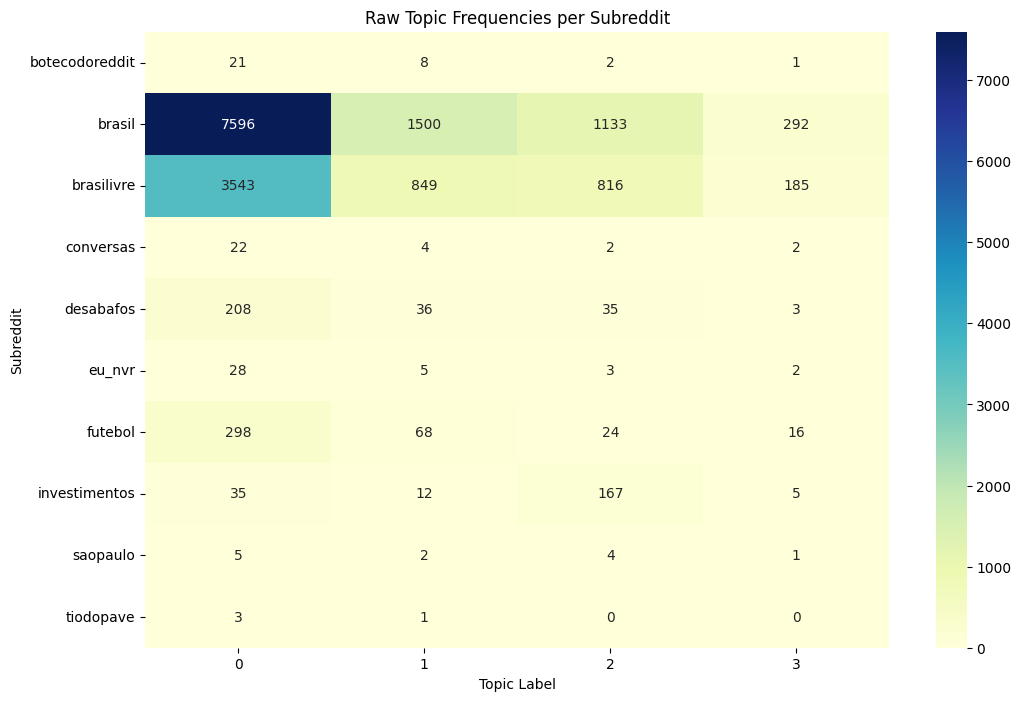

In [35]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(raw_topic_frequencies, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Raw Topic Frequencies per Subreddit')
plt.xlabel('Topic Label')
plt.ylabel('Subreddit')
plt.show()

**Reasoning**:
Normalize the raw topic frequencies by dividing each row by its sum to get proportions and then display the result.



In [36]:
normalized_topic_frequencies = raw_topic_frequencies.div(raw_topic_frequencies.sum(axis=1), axis=0)
display(normalized_topic_frequencies.head())

topic_label,0,1,2,3
subreddit,,,,
botecodoreddit,0.656250,0.250000,0.062500,0.031250
brasil,0.721985,0.142572,0.107689,0.027754
brasilivre,0.656963,0.157426,0.151307,0.034304
conversas,0.733333,0.133333,0.066667,0.066667
desabafos,0.737589,0.127660,0.124113,0.010638


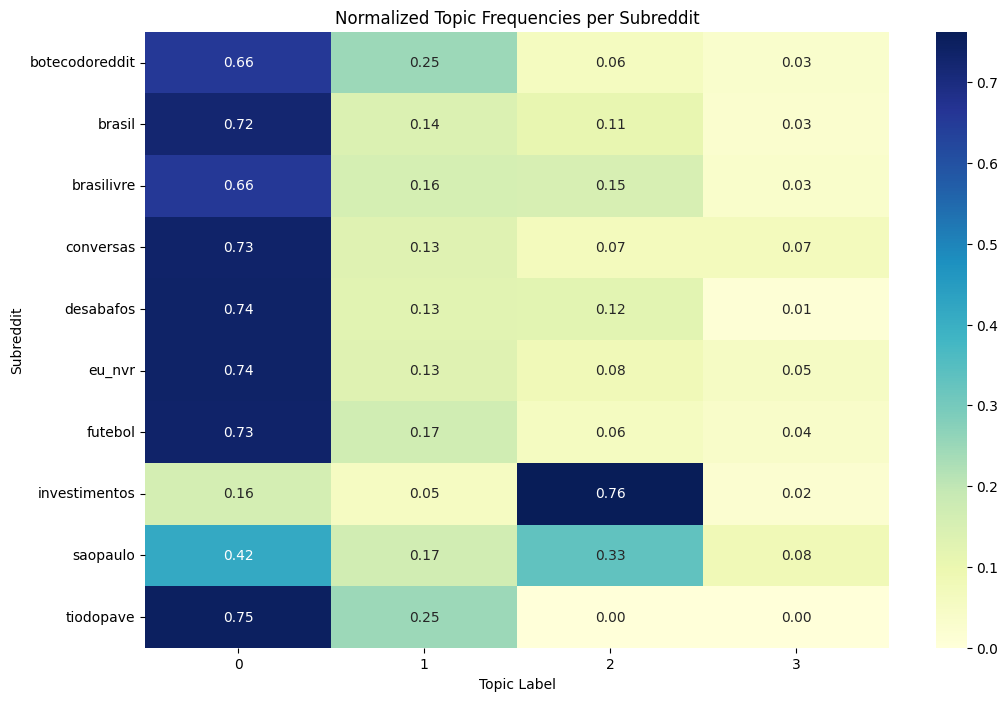

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_topic_frequencies, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Topic Frequencies per Subreddit")
plt.xlabel("Topic Label")
plt.ylabel("Subreddit")
plt.show()

In [38]:
total_comments_per_subreddit = comments.groupby('subreddit').size()
print("Total comments per subreddit:")
display(total_comments_per_subreddit)

Total comments per subreddit:


,0
subreddit,
botecodoreddit,86
brasil,21938
brasilivre,12122
conversas,173
desabafos,737
eu_nvr,104
futebol,1226
investimentos,420
saopaulo,37


topic_label,0,1,2,3
subreddit,,,,
botecodoreddit,21,8,2,1
brasil,7596,1500,1133,292
brasilivre,3543,849,816,185
conversas,22,4,2,2
desabafos,208,36,35,3
eu_nvr,28,5,3,2
futebol,298,68,24,16
investimentos,35,12,167,5
saopaulo,5,2,4,1


topic_label,0,1,2,3
subreddit,,,,
botecodoreddit,0.244186,0.093023,0.023256,0.011628
brasil,0.346249,0.068375,0.051646,0.013310
brasilivre,0.292279,0.070038,0.067316,0.015262
conversas,0.127168,0.023121,0.011561,0.011561
desabafos,0.282225,0.048847,0.047490,0.004071
eu_nvr,0.269231,0.048077,0.028846,0.019231
futebol,0.243067,0.055465,0.019576,0.013051
investimentos,0.083333,0.028571,0.397619,0.011905
saopaulo,0.135135,0.054054,0.108108,0.027027


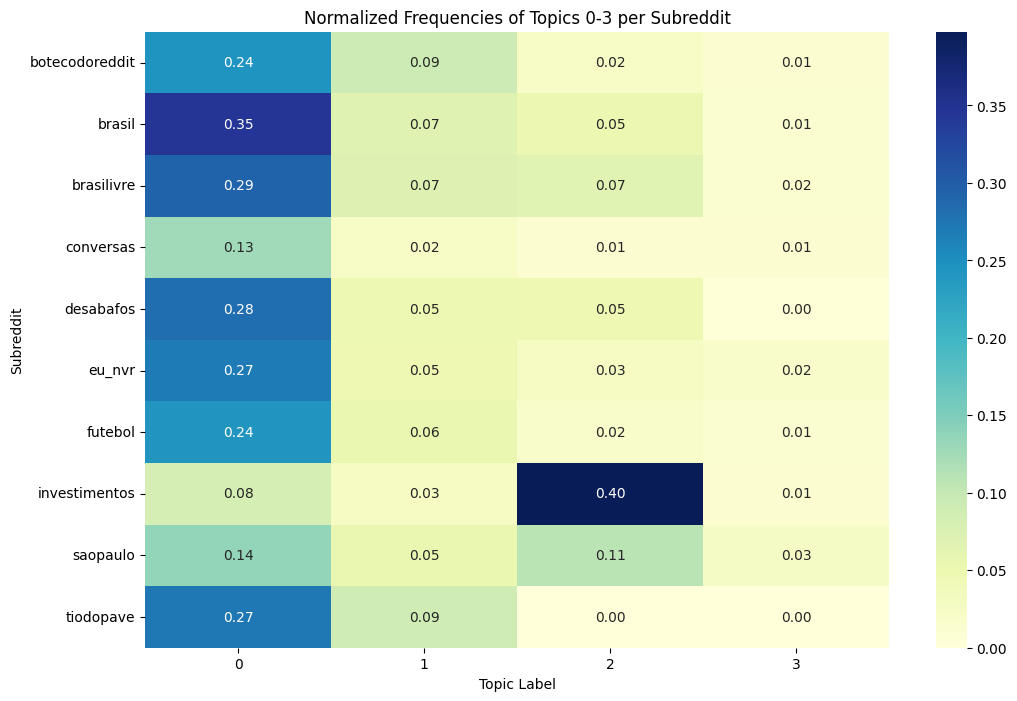

In [39]:
topics_to_normalize = filtered_data[filtered_data['topic_label'].isin([0, 1, 2, 3])].copy()

raw_topics_0_to_3_frequencies = topics_to_normalize.groupby(['subreddit', 'topic_label']).size().unstack(fill_value=0)
display(raw_topics_0_to_3_frequencies)

normalized_topics_0_to_3_frequencies = raw_topics_0_to_3_frequencies.div(total_comments_per_subreddit, axis=0)
display(normalized_topics_0_to_3_frequencies)

plt.figure(figsize=(12, 8))
sns.heatmap(normalized_topics_0_to_3_frequencies, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Frequencies of Topics 0-3 per Subreddit")
plt.xlabel("Topic Label")
plt.ylabel("Subreddit")
plt.show()